# 04 — Calibration
In this notebook, we calibrate parameters of Kou's pricing model using real world data and back test the LRM hedging using the fitted parameters. We also show that daily log returns of SPY data has leptokurtic feature, which matches leptokurtic property of Kou's jump diffusion model. But we find a discrepancy that with calibrated paramters, simulated returns of Kou's model has rather negative skewness, while SPY returns turns out to have positive skewness.

In [506]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.optimize import brentq
from scipy.integrate import quad
from scipy.optimize import minimize
from numpy.polynomial.laguerre import laggauss
from math import sqrt
from dateutil import parser
from dateutil.tz import tzutc

sns.set_style('darkgrid')
def rng(seed=None):
    return np.random.default_rng(seed)

In [507]:
## Randomly generated stock paths as Geometric Brownian Motions

def GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps):
    """Simulates stock paths as geometric Brownian Motions
    Inputs:
    S0 (float): Underlying stock price at time 0
    sigma (float): Yearly volatility
    t (float): Time to expiration (years)
    r (float): Risk-free interest rate
    mu (float): Drift of log-returns
    n_sims (int): Number of simulated paths
    n_steps (int): Number of steps in each simulated path, each step interval has length t/n_steps
    
    Return (np.array): Array of stock paths
    """
    
    dt = t/n_steps
    noise = np.random.normal(loc = 0, scale = 1, size = (n_sims, n_steps))
    log_returns = (mu+r-sigma**2*(0.5))*dt + sigma*np.sqrt(dt)*noise
    exponent = np.cumsum(log_returns, axis = 1)
    paths = S0*np.exp(exponent)
    paths_with_start = np.insert(paths, 0, S0, axis = 1)

    return paths_with_start

##Black-Scholes Functions
def bs_call(S0, K, sigma, t, r):
    '''
    Black-Scholes Call Option formula
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes value of call option (float)
    '''
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    d2 = d1 - sigma*np.sqrt(t)
    
    
    call_value = S0*norm.cdf(d1) - K*np.exp(-r*t)*norm.cdf(d2)
    
    
    return call_value

##Implied volatility functions
def implied_volatility_call(market_price, S0, K, t, r, sigma_bounds=(1e-6, 2)):
    """
    Returns the implied volatility of a call option given spot price, strike, time to expiration, 
    and risk-free-interest rate.
    
    Inputs:
    market_price (float): Market price of call option
    S0 (float): Spot price of stock
    K (float): strike price
    t (float): time-to-expiration
    r (float): risk-free-interest rate
    
    Returns:
    Implied volatility (float)
    
    """
    def objective(sigma):
        return bs_call(S0, K, sigma, t, r) - market_price

    try:
        return brentq(objective, *sigma_bounds)
    except ValueError:
        return np.nan    

In [508]:

def double_exponential_jump_sums(nums_jumps, p, eta1, eta2, rg):
    """
    return total jump sizes sum of Y_i's during a small time interval dt
    nums_jumps: array of numbers of jumps occuring during dt for different stock paths
    size of each jump Y_i is double exponential, namely +Exp(eta1) with probability p, 
    or -Exp(eta2) with probability 1-p.
    
    Vectorized implementation using a Binomial split and Gamma sums.

    total_Y = Sum_{j=1..nums_jumps} Y_j 
          = Gamma(nums_up_jumps, scale=1/eta1) /
            - Gamma(nums_down_jumps, scale=1/eta2).

    """
    nums_jumps = np.asarray(nums_jumps, dtype=np.int64)
    if nums_jumps.ndim == 0:
        nums_jumps = nums_jumps[None]
    
    # Divide all jumps into upward and downward jumps by binomial random draws
    nums_up_jumps = rg.binomial(nums_jumps, p)
    nums_down_jumps = nums_jumps - nums_up_jumps
    
    # Gamma(shape=nums_jumps, scale=1/eta). For k=0, we want 0, which means no jump. Handle zeros safely.
    total_Y_up = np.zeros_like(nums_jumps, dtype=float)
    up_jumps_indices = nums_up_jumps > 0 
    if up_jumps_indices.any():
        total_Y_up[up_jumps_indices] = rg.gamma(shape=nums_up_jumps[up_jumps_indices], scale=1.0/eta1)
    
    total_Y_down = np.zeros_like(nums_jumps, dtype=float)
    down_jumps_indices = nums_down_jumps > 0
    if down_jumps_indices.any():
        total_Y_down[down_jumps_indices] = rg.gamma(shape=nums_down_jumps[down_jumps_indices], scale=1.0/eta2)
    
    total_Y = total_Y_up - total_Y_down
    return total_Y.reshape(nums_jumps.shape)


def kou_paths(
    S0: float,
    T: float,
    n_steps: int,
    n_paths: int,
    sigma: float,
    lam: float,
    p: float,
    eta1: float,
    eta2: float,
    mu: float = None,
    r: float = None,
    seed: int = 42,
):
    """
    Simulate paths for Kou's double-exponential jump-diffusion.
    
    Args:
        S0: underlying stock price at time 0
        T: time to expiration in years
        n_steps: time steps
        n_paths: number of simulated paths
        sigma: yearly volatility
        lam: yearly jump intensity
        p: probability of up-jump (Y ~ +Exp(eta1)); q = 1 - p (down-jump Y ~ -Exp(eta2))
        eta1: rate of upward exponential; must satisfy eta1 > 1 for finite E[V]
        eta2: rate of downward exponential (> 0)
        mu: physical drift (use if r is None)
        r: risk-free interest rate; if provided, simulator uses risk-neutral drift (preferred for pricing)
        seed: RNG seed
    
    Returns:
        times (shape n_steps+1,), paths array (shape n_steps+1, n_paths)
    """
    assert S0 > 0 and T > 0 and n_steps >= 1 and n_paths >= 1
    assert sigma >= 0 and lam >= 0
    assert 0.0 <= p <= 1.0 and eta1 > 0 and eta2 > 0
    
    dt = T / n_steps
    rg = rng(seed)
    
    # Drift term in log S increment:
    if r is not None:
        # Risk-neutral drift uses zeta = E[e^Y]-1
        zeta = p * (eta1 / (eta1 - 1.0)) + (1.0 - p) * (eta2 / (eta2 + 1.0)) - 1.0
        mu_tilde = (r - 0.5 * sigma**2 - lam * zeta)
    else:
        if mu is None:
            raise ValueError("Provide either mu (physical) or r (risk-neutral).")
        mu_tilde = (mu - 0.5 * sigma**2)
    
    # Pre-allocate
    paths = np.empty((n_steps + 1, n_paths), dtype=float)
    paths[0, :] = S0
    sqrt_dt = np.sqrt(dt)
    
    # Draw Brownian increments and Poisson jump counts
    dW = rg.normal(loc=0.0, scale=sqrt_dt, size=(n_steps, n_paths))
    J = rg.poisson(lam=lam * dt, size=(n_steps, n_paths))
    
    # For each time step, compute jump-sum and log increment
    for t in range(n_steps):
        Y_sum = double_exponential_jump_sums(J[t], p=p, eta1=eta1, eta2=eta2, rg=rg)
        dX = mu_tilde * dt + sigma * dW[t] + Y_sum
        paths[t + 1] = paths[t] * np.exp(dX)
    
    times = np.linspace(0.0, T, n_steps + 1)
    return times, paths


In [509]:
def kou_cumulant(theta, r, sigma, lam, p, eta1, eta2):
    """
    Kou cumulant G(theta) for the log-return process X_T = ln S_T - ln S_0 under Q.

    Definition:
        G(theta) = theta * (r - lambda*zeta - 0.5*sigma^2) + 0.5*sigma^2 * theta^2
                   + lambda * ( p * eta1 / (eta1 - theta) + (1-p) * eta2 / (eta2 + theta) - 1 )

    where zeta = E[e^Y - 1] for Y ~ double-exponential jumps:
        zeta = p * eta1/(eta1 - 1) + (1-p) * eta2/(eta2 + 1) - 1

    Parameters
    ----------
    theta : float or complex or array-like
        Laplace variable. Valid for Re(theta) in (-eta2, eta1).
        Can be a numpy array of complex numbers (e.g., theta = c+1j*u + 1).
    r : float
        Risk-free rate (continuous compounding).
    sigma : float
        Diffusion volatility (>= 0).
    lam : float
        Jump intensity lambda (>= 0).
    p : float
        Probability of an upward jump (in (0,1)).
    eta1 : float
        Rate of upward exponential jump sizes (+Exp(eta1)); must satisfy eta1 > 1 for finiteness of E[e^Y].
    eta2 : float
        Rate of downward exponential jump sizes (-Exp(eta2)); must satisfy eta2 > 0.

    Returns
    -------
    G : complex ndarray or complex
        Same shape as theta. Complex-valued in general.
    """
    
    theta = np.asarray(theta, dtype=np.complex128)

    # Risk-neutral compensator for jumps
    zeta = p * (eta1 / (eta1 - 1.0)) + (1.0 - p) * (eta2 / (eta2 + 1.0)) - 1.0

    drift_term = theta * (r - lam * zeta - 0.5 * sigma**2)
    diff_term  = 0.5 * (sigma**2) * (theta**2)
    jump_term  = lam * ( p * (eta1 / (eta1 - theta)) + (1.0 - p) * (eta2 / (eta2 + theta)) - 1.0 )

    return drift_term + diff_term + jump_term


def kou_call_laplace_transform(xi, S0, T, r, sigma, lam, p, eta1, eta2):
    """
    Bilateral Laplace transform of the call price C_T(k) w.r.t. k = -ln K.

        Chat(xi) = ∫_{-∞}^{∞} e^{-xi k} C_T(k) dk
                 = e^{-rT} * S0^{xi+1} / [ xi (xi+1) ] * exp( G(xi+1) * T )

    where G is the Kou cumulant from `kou_cumulant`.

    Parameters
    ----------
    xi : float/complex or array-like
        Laplace variable for k. Must satisfy Re(xi) > 0 and Re(xi+1) in (-eta2, eta1).
    S0 : float
        Spot price (S0 > 0).
    T : float
        Time to maturity in years (T >= 0).
    r, sigma, lam, p, eta1, eta2 : floats
        Kou model parameters under the risk-neutral measure.

    Returns
    -------
    Chat : complex ndarray or complex
        Transform values at xi; same shape as xi.
    """

    xi = np.asarray(xi, dtype=np.complex128)
    theta = xi+1
    G = kou_cumulant(theta, r, sigma, lam, p, eta1, eta2)
    # compute S0^(xi+1) robustly for complex xi
    return np.exp(-r*T) * (S0**(xi+1)) * np.exp(G*T) / (xi * (xi + 1))


def kou_call_laplace_price(S0, K, T, r, sigma, lam, p, eta1, eta2,
                           c=None, u_max=200.0, N=20000):
    if c is None:
        c = 0.5 * min(eta1 - 1.0, 1.0)
        c = max(c, 1e-3)
    k = -np.log(K)
    u = np.linspace(1e-6, u_max, N)
    xi = c + 1j*u
    Chat = kou_call_laplace_transform(xi, S0, T, r, sigma, lam, p, eta1, eta2)
    integrand = np.real(np.exp(1j*u*k) * Chat)
    du = (u_max - u[0]) / (N - 1)
    val = np.exp(c*k)/np.pi * np.trapezoid(integrand, dx=du)
    return float(max(val, 0.0))


def kou_call_delta(S0, K, T,r, sigma, lam, p, eta1, eta2, c= None, u_max = 200, N = 20000):
    if T <= 0:
        return 1.0 if S0 > K else 0.0
    if c is None:
        c = min(0.5, max(1e-3, 0.25*(eta1 - 1)))  # choose 0 < c < eta1 - 1

    u = np.linspace(0.0, u_max, int(N) + 1)
    du = u[1] - u[0]
    xi = c + 1j*u
    theta = xi + 1.0
    phase = np.exp(1j * u * np.log(S0 / K))

    G = kou_cumulant(theta, r, sigma, lam, p, eta1, eta2)  # per-unit-time
    integrand = np.exp(G * T) * phase / xi
    re = integrand.real
    integral = du * (0.5 * re[0] + re[1:-1].sum() + 0.5 * re[-1])

    return float(math.exp(-r * T) * (S0 / K) ** c * (integral / math.pi))


In [510]:
##Implied volatility functions for Kou's model
def implied_volatility_call_kou(market_price, S0, K, T, r,lam, p, eta1, eta2, sigma_bounds=(1e-6, 2)):
    """
    Returns the implied volatility of a call option given spot price, strike, time to expiration, 
    and risk-free-interest rate.
    
    Inputs:
    market_price (float): Market price of call option
    S0 (float): Spot price of stock
    K (float): strike price
    t (float): time-to-expiration
    r (float): risk-free-interest rate
    
    Returns:
    Implied volatility (float)
    
    """
    def objective(sigma):
        return kou_call_laplace_price(S0, K, T, r, sigma, lam, p, eta1, eta2) - market_price

    try:
        return brentq(objective, *sigma_bounds)
    except ValueError:
        return np.nan    

In [511]:
#Let's design function for LRM hedging.

from numpy.polynomial.laguerre import laggauss

def E_exp_kY(k, p, eta1, eta2):
    # E[e^{kY}] for Kou jumps
    return p * (eta1 / (eta1 - k)) + (1.0 - p) * (eta2 / (eta2 + k))

def E_eY_minus1_sq(p, eta1, eta2):
    Ey  = E_exp_kY(1.0, p, eta1, eta2)
    E2y = E_exp_kY(2.0, p, eta1, eta2)
    return E2y - 2.0*Ey + 1.0

def _kou_expectation(fun_y, p, eta1, eta2, n=16):
    # Split-domain Gauss–Laguerre quadrature:
    # y >= 0 branch: density eta1 * exp(-eta1 y)
    # y < 0 branch: change var u=-y >= 0 with density eta2 * exp(-eta2 u)
    x, w = laggauss(n)  # ∫_0^∞ e^{-x} g(x) dx ≈ sum w_i g(x_i)
    # positive jumps (y = x/eta1)
    term_pos = np.sum(w * np.array([fun_y(+xx/eta1) for xx in x]))
    # negative jumps (y = -x/eta2)
    term_neg = np.sum(w * np.array([fun_y(-xx/eta2) for xx in x]))
    return p * term_pos + (1.0 - p) * term_neg

def phi_LRM_scalar(s, tau, K, r, sigma, lam, p, eta1, eta2,
                   price_fun, delta_fun, u_max=200, N=4000, quad_n=16):
    # F = call price under Kou (Laplace); Fs = Kou delta
    F  = price_fun(s, K, tau, r, sigma, lam, p, eta1, eta2,
                   c=None, u_max=u_max, N=N)
    Fs = delta_fun(s, K, tau, r, sigma, lam, p, eta1, eta2,
                   c=None, u_max=u_max, N=N)

    def integrand(y):
        Fy = price_fun(s*np.exp(y), K, tau, r, sigma, lam, p, eta1, eta2,
                       c=None, u_max=u_max, N=N)
        return (Fy - F - s*(np.exp(y)-1.0)*Fs) * (np.exp(y)-1.0)

    jump_corr = lam * _kou_expectation(integrand, p, eta1, eta2, n=quad_n)
    denom = s * (sigma**2 + lam * E_eY_minus1_sq(p, eta1, eta2))
    return Fs + jump_corr / denom


In [512]:
##Functions for option data obtained through y-finance
def find_tte_yf_options(expiration_date,last_trade_date):
    '''returns time measured in years as a float between two dates
    
    Inputs:
    expiration_date (str): 'YYYY-MM-DD'
    last_trade_date (pandas._libs.tslibs.timestamps.Timestamp)
    
    Returns:
    Float of time to expiration in years
    '''
    tte = (datetime.datetime.strptime(expiration_date+'-21-30', "%Y-%m-%d-%H-%M").replace(tzinfo=tzutc()) -\
last_trade_date).total_seconds()/(60*60*24*365)
    
    return tte


def yf_find_approx_spot(stock_data, last_trade_date):
    """
    Finds approximate spot price at the time of last trade.
    The spot price is approximate since yfinance does not provide 1-second data, only minute-by-minute.

    Parameters:
    stock_data (pd.Series or pd.DataFrame): stock prices with DatetimeIndex
    last_trade_date (pd.Timestamp): timestamp of last trade of option contract

    Returns:
    float: approximate spot price, or NaN if unavailable
    """
    # Round timestamp to the minute (zero out seconds)
    ts = last_trade_date.replace(second=0)

    try:
        return stock_data.loc[ts].iloc[0]
    except KeyError:
        return float('nan')
    


In [496]:
#Option data from yfinance


stock_symbol = 'SPY'
ticker = yf.Ticker(stock_symbol)
stock_data = yf.download(stock_symbol, period = '1d', interval = '1m')



expirations = ticker.options


#Create array to store options data
option_data = []

for date in expirations:
    chain = ticker.option_chain(date)

    # Add expiration and label
    calls = chain.calls.copy()
    calls['expiration'] = date
    calls['option_type'] = 'call'

    option_data.append(calls)
   

# Combine all into one DataFrame and delete implied volatility column since we'll recalculate.
options_data = pd.concat(option_data, ignore_index=True)
options_data = options_data.drop(columns=['impliedVolatility'])


#Delete any options that were traded in the interval of historical stock values obtained
start_date = stock_data.index[0]
options_data = options_data[options_data['lastTradeDate']>=start_date]


#Insert column of time to expiration in years of the option contract measured from time of last trade
options_data['time_to_expiration'] = options_data.apply(
lambda row: find_tte_yf_options(expiration_date = row['expiration'],
                               last_trade_date = row['lastTradeDate']),
    axis = 1
)


#Add in column of the spot price of stock when the option trade occured.
options_data['spot_price'] = options_data.apply(
    lambda row: yf_find_approx_spot(stock_data['Close'], row['lastTradeDate']),
    axis=1
)
options_data = options_data.dropna()


#Create data frames that keeps relevant information and separate calls from puts.
options_data = options_data[['strike', 'lastPrice', 'lastTradeDate',\
                             'expiration', 'option_type','time_to_expiration', 'spot_price']]
options_data_calls = options_data[(options_data['option_type'] == 'call')].copy()

#Add implied volatility column in calls data frame 
r = 0.039



options_data_calls['implied_volatility'] = options_data_calls.apply(
    lambda row: implied_volatility_call(
        market_price=row['lastPrice'],
        S0 = row['spot_price'],
        K=row['strike'],
        t=row['time_to_expiration'],
        r=r
    ),
    axis=1
)


#Remove rows with undefined values
options_data_calls = options_data_calls.dropna()

/var/folders/nr/0jkb8n7x4kq3f6129c18jg8c0000gn/T/ipykernel_38940/1487434463.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(stock_symbol, period = '1d', interval = '1m')
[*********************100%***********************]  1 of 1 completed


In [513]:
for date in expirations:
    
    call_data = options_data_calls[options_data_calls['expiration'] == date]
    call_strikes = call_data['strike']
    call_imp_vol = call_data['implied_volatility']
    
    
    #plt.plot(call_strikes.values, call_imp_vol.values, label = 'Call')
    
    #plt.title(f'Expiration date: {date}')
    #plt.legend()
    #plt.show()

In [514]:
dates = ['2026-03-20']#Insert dates that have reasonable volatility smiles

options_data_calls_cleaned = options_data_calls[options_data_calls['expiration'].isin(dates)]




In [515]:
options_data_calls_cleaned

,strike,lastPrice,lastTradeDate,expiration,option_type,time_to_expiration,spot_price,implied_volatility
2125,420.0,258.26,2025-11-06 18:36:17+00:00,2026-03-20,call,0.367454,671.960022,0.337680
2126,425.0,253.28,2025-11-06 18:36:59+00:00,2026-03-20,call,0.367452,671.960022,0.323310
2127,430.0,248.30,2025-11-06 18:36:35+00:00,2026-03-20,call,0.367453,671.960022,0.308321
2130,445.0,233.36,2025-11-06 15:49:40+00:00,2026-03-20,call,0.367771,671.400024,0.328014
2132,455.0,226.25,2025-11-06 15:16:21+00:00,2026-03-20,call,0.367834,673.750000,0.339474
2135,470.0,210.29,2025-11-06 20:41:55+00:00,2026-03-20,call,0.367215,671.869995,0.344394
2139,490.0,190.24,2025-11-06 18:59:01+00:00,2026-03-20,call,0.367411,671.500000,0.311931
2141,500.0,179.69,2025-11-06 20:57:55+00:00,2026-03-20,call,0.367184,670.190002,0.312541
2143,510.0,171.39,2025-11-06 15:44:43+00:00,2026-03-20,call,0.367780,671.138000,0.311317
2146,525.0,156.00,2025-11-06 16:52:57+00:00,2026-03-20,call,0.367650,670.390015,0.288095


In [516]:
###Calibrate Kou model to option data using gradient descent

def objective(params, data, r):
    sigma, lam, p, eta1, eta2 = params

    error = 0
    for _, row in data.iterrows():
        model_price = kou_call_laplace_price(
                S0=row['spot_price'], 
                K=row['strike'], 
                T=row['time_to_expiration'], 
                r=r, 
                sigma = sigma, 
                lam = lam, 
                p = p, 
                eta1 = eta1, 
                eta2 = eta2,
                c=None, u_max=200.0, N=20000)
        market_price = row['lastPrice']
        error += (model_price - market_price) ** 2
    return error / len(data)

In [555]:
#need to create a reasonable first guess and set bounds for our model calibration


initial_guess = [0.2, 3, 0.8, 15, 20]    #sigma, lam, p, eta1, eta2

bounds = [(0.05, 1), (0.01, 30), (0.01, 1), (0, 50), (0,50)]

r = .039


data_sample = options_data_calls_cleaned.sample(30)


result = minimize(
    objective,
    initial_guess,
    args=(data_sample, r),
    bounds=bounds,
    method='L-BFGS-B',
    options={
        'disp': True,
        'maxiter': 20,       
        'ftol': 1e-4,         
        'gtol': 1e-4          
    }
)
calibrated_params = result.x

/var/folders/nr/0jkb8n7x4kq3f6129c18jg8c0000gn/T/ipykernel_38940/289799136.py:14: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = minimize(


In [556]:
sigma, lam, p, eta1, eta2 = calibrated_params

In [557]:
#value of calibrated parameters

sigma, lam, p, eta1, eta2 

(np.float64(0.05114903999337236),
 np.float64(5.560517657476609),
 np.float64(0.01),
 np.float64(6.3834078607990605),
 np.float64(19.534136828269713))

In [558]:
#Backtest hedging strategies using delta hedging and LRM hedging with fitted parameters

stock_data =yf.download(stock_symbol, period = '2y', interval = '1d')

/var/folders/nr/0jkb8n7x4kq3f6129c18jg8c0000gn/T/ipykernel_38940/2836934166.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data =yf.download(stock_symbol, period = '2y', interval = '1d')
[*********************100%***********************]  1 of 1 completed


In [559]:
stock_data

Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2023-11-08,426.234192,427.053026,423.914147,426.526622,61746000
2023-11-09,422.910095,427.423455,422.481178,427.384454,83174400
2023-11-10,429.509552,429.821497,422.900364,424.996222,89462200
2023-11-13,429.100128,430.211392,427.374731,428.164322,52236100
2023-11-14,437.424988,438.721468,434.851484,435.075700,97176900
...,...,...,...,...,...
2025-11-03,683.340027,685.799988,679.940002,685.669983,57315000
2025-11-04,675.239990,679.960022,674.580017,676.109985,78427000


In [560]:
rol_sigmas = (np.log((stock_data['Close'][stock_symbol].pct_change()+1)).std()*np.sqrt(252))

In [561]:
rol_sigmas

np.float64(0.16202448043220596)

Delta-hedged: call payout discounted - total stock profit:  49.9480
LRM-hedged: call payout discounted - total stock profit:  54.2886
Kou call price     :  57.2624


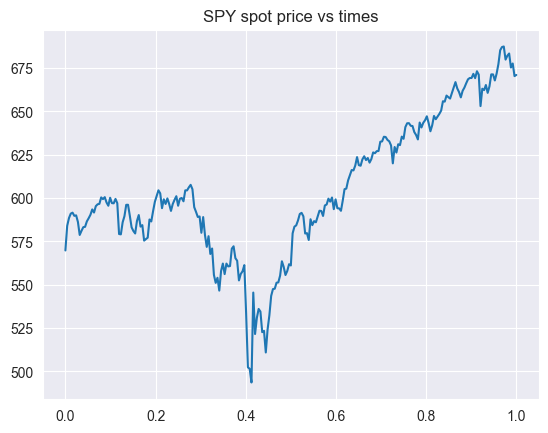

In [567]:
T = 1

steps = 252

dt = T/steps

stock_path = np.array(stock_data['Close'][stock_symbol].values[-steps-1:]) # one year stock path ending at today

rol_sigmas = (np.log((stock_data['Close'][stock_symbol].pct_change()+1)).rolling(window = 21).std()*np.sqrt(252))[-steps-1:]

rol_vols = rol_sigmas**2

K = stock_path[0]

times = np.linspace(0,T, steps + 1)


plt.plot(times, stock_path)
plt.title("SPY spot price vs times")

# -------- Delta positions (fix: use sigma, not variance) --------
deltas = np.zeros(steps)
for i in range(steps):
    deltas[i] = kou_call_delta(
        stock_path[i], K, (T - times)[i], r,
        float(rol_sigmas.iloc[i]),  # <-- use volatility
        lam, p, eta1, eta2, c=None, u_max=200, N=3000
    )

# -------- LRM positions --------
lrm_positions = np.zeros(steps)
for i in range(steps):
    lrm_positions[i] = phi_LRM_scalar(
        s=stock_path[i],
        tau=(T - times)[i],
        K=K, r=r, sigma=float(rol_sigmas.iloc[i]),
        lam=lam, p=p, eta1=eta1, eta2=eta2,
        price_fun=kou_call_laplace_price,
        delta_fun=kou_call_delta,
        u_max=200, N=3000, quad_n=12
    )

# -------- Discounted P&L --------
stock_profits_delta = (stock_path[1:] - stock_path[:-1]*np.exp(r*dt)) \
                      * np.exp(-r*times[1:]) * deltas
total_stock_profit_delta = float(stock_profits_delta.sum())

stock_profits_LRM = (stock_path[1:] - stock_path[:-1]*np.exp(r*dt)) \
                    * np.exp(-r*times[1:]) * lrm_positions
total_stock_profit_LRM = float(stock_profits_LRM.sum())

call_payout_discounted = float(np.maximum(stock_path[-1] - K, 0.0) * np.exp(-r*T))

# Hedger’s P&L from short call after hedging
call__hedged_delta = call_payout_discounted - total_stock_profit_delta
call__hedged_LRM   = call_payout_discounted - total_stock_profit_LRM

# Price at t0 (use current vol at i=0)
sigma0 = float(rol_sigmas.iloc[0])
kou_call_price = kou_call_laplace_price(stock_path[0], K, T, r, sigma0, lam, p, eta1, eta2, c=None, u_max=200, N=3000)

print(f"Delta-hedged: call payout discounted - total stock profit: {call__hedged_delta: .4f}")
print(f"LRM-hedged: call payout discounted - total stock profit: {call__hedged_LRM: .4f}")
#print(f"Unhedged short-call : {( call_payout_discounted ): .4f}")
print(f"Kou call price     : {kou_call_price: .4f}")

Delta-hedged: call payout discounted - total stock profit:  48.2260
LRM-hedged: call payout discounted - total stock profit:  47.9417
Kou call price     :  53.8259


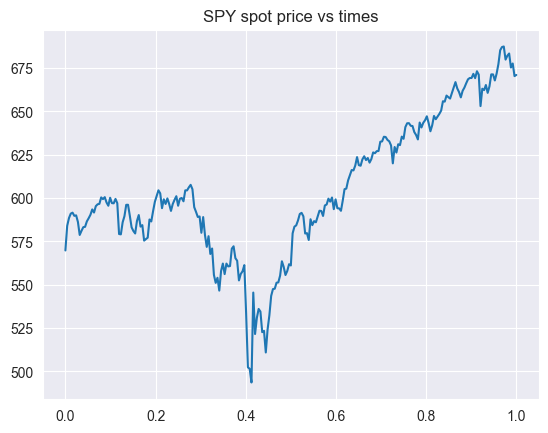

In [572]:
sigma=0.2
lam=3
p=0.8
eta1=15
eta2=20

T = 1

steps = 252

dt = T/steps

stock_path = np.array(stock_data['Close'][stock_symbol].values[-steps-1:]) # one year stock path ending at today

rol_sigmas = (np.log((stock_data['Close'][stock_symbol].pct_change()+1)).rolling(window = 21).std()*np.sqrt(252))[-steps-1:]

rol_vols = rol_sigmas**2

K = stock_path[0]

times = np.linspace(0,T, steps + 1)


plt.plot(times, stock_path)
plt.title("SPY spot price vs times")

# -------- Delta positions (fix: use sigma, not variance) --------
deltas = np.zeros(steps)
for i in range(steps):
    deltas[i] = kou_call_delta(
        stock_path[i], K, (T - times)[i], r,
        float(rol_sigmas.iloc[i]),  # <-- use volatility
        lam, p, eta1, eta2, c=None, u_max=200, N=3000
    )

# -------- LRM positions --------
lrm_positions = np.zeros(steps)
for i in range(steps):
    lrm_positions[i] = phi_LRM_scalar(
        s=stock_path[i],
        tau=(T - times)[i],
        K=K, r=r, sigma=float(rol_sigmas.iloc[i]),
        lam=lam, p=p, eta1=eta1, eta2=eta2,
        price_fun=kou_call_laplace_price,
        delta_fun=kou_call_delta,
        u_max=200, N=3000, quad_n=12
    )

# -------- Discounted P&L --------
stock_profits_delta = (stock_path[1:] - stock_path[:-1]*np.exp(r*dt)) \
                      * np.exp(-r*times[1:]) * deltas
total_stock_profit_delta = float(stock_profits_delta.sum())

stock_profits_LRM = (stock_path[1:] - stock_path[:-1]*np.exp(r*dt)) \
                    * np.exp(-r*times[1:]) * lrm_positions
total_stock_profit_LRM = float(stock_profits_LRM.sum())

call_payout_discounted = float(np.maximum(stock_path[-1] - K, 0.0) * np.exp(-r*T))

# Hedger’s P&L from short call after hedging
call__hedged_delta = call_payout_discounted - total_stock_profit_delta
call__hedged_LRM   = call_payout_discounted - total_stock_profit_LRM

# Price at t0 (use current vol at i=0)
sigma0 = float(rol_sigmas.iloc[0])
kou_call_price = kou_call_laplace_price(stock_path[0], K, T, r, sigma0, lam, p, eta1, eta2, c=None, u_max=200, N=3000)

print(f"Delta-hedged: call payout discounted - total stock profit: {call__hedged_delta: .4f}")
print(f"LRM-hedged: call payout discounted - total stock profit: {call__hedged_LRM: .4f}")
#print(f"Unhedged short-call : {( call_payout_discounted ): .4f}")
print(f"Kou call price     : {kou_call_price: .4f}")

## Leptokurtosis in daily returns
The kurtosis and skewness are defined as $K = \mathbb{E}[\dfrac{(X-\mu)^4}{\sigma^4}]$, $S = \mathbb{E}[\dfrac{(X-\mu)^3}{\sigma^3}]$. For the standard normal density $K = 3$. If $K > 3$ then the distribution is called leptokurtic and the distribution will have a higher peak and two heavier tails than those of the normal distribution. For example the double exponential distribution is leptokurtic.


We test the following features of above SPY's daily log returns and simulated Kou's log returns under calibrated parameters: 
- Excess kurtosis (kurtosis minus 3; positive values indicate leptokurtosis),
- Skewness,
- Jarque–Bera normality test,
- Histogram with a normal overlay, and a quantile–quantile plot versus the normal distribution

Sample mean: 0.000906
Sample standard deviation: 0.010207
Excess kurtosis (positive means leptokurtic): 21.622
Skewness: 0.773
Jarque–Bera test statistic: 9604.90, p-value: 0


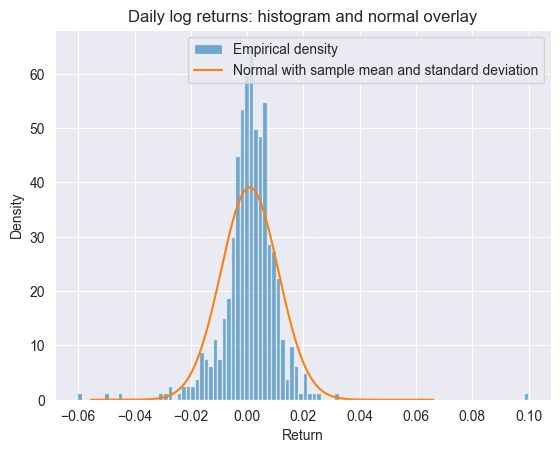

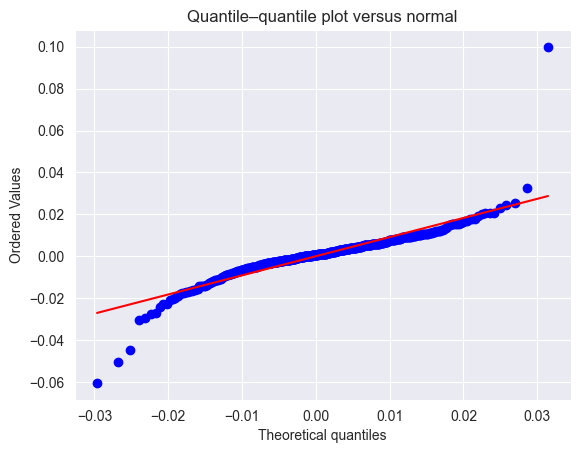

In [573]:
log_returns = np.log(stock_data['Close', stock_symbol].pct_change()+1).dropna()

returns = log_returns


mean_r = returns.mean()
sd_r = returns.std(ddof=1)

excess_kurtosis = stats.kurtosis(returns, fisher=True, bias=False)
skewness = stats.skew(returns, bias=False)

#small p-value (<.05) gives high significance that data is not normally distributed

jb_stat, jb_p = stats.jarque_bera(returns)

print(f"Sample mean: {mean_r:.6f}")
print(f"Sample standard deviation: {sd_r:.6f}")
print(f"Excess kurtosis (positive means leptokurtic): {excess_kurtosis:.3f}")
print(f"Skewness: {skewness:.3f}")
print(f"Jarque–Bera test statistic: {jb_stat:.2f}, p-value: {jb_p:.3g}")

# Histogram with normal overlay
xs = np.linspace(returns.quantile(0.001), returns.quantile(0.999), 400)
normal_pdf = stats.norm.pdf(xs, loc=mean_r, scale=sd_r)

plt.figure()
plt.hist(returns, bins=100, density=True, alpha=0.6, label='Empirical density')
plt.plot(xs, normal_pdf, label='Normal with sample mean and standard deviation')
plt.title('Daily log returns: histogram and normal overlay')
plt.xlabel('Return')
plt.ylabel('Density')
plt.legend()
plt.show()

# Quantile–quantile plot
plt.figure()
stats.probplot(returns, dist="norm", sparams=(mean_r, sd_r), plot=plt)
plt.title('Quantile–quantile plot versus normal')
plt.show()


**Interpretation.**  
If excess kurtosis is clearly positive and the quantile–quantile plot curves away from the straight line in the tails, the daily return distribution is **leptokurtic**, consistent with occasional jumps.


Paths: 10000, Steps per path: 252
Average skewness across paths:        -7.4193  (SE 0.0391)
Average excess kurtosis across paths:  87.0543  (SE 0.4913)


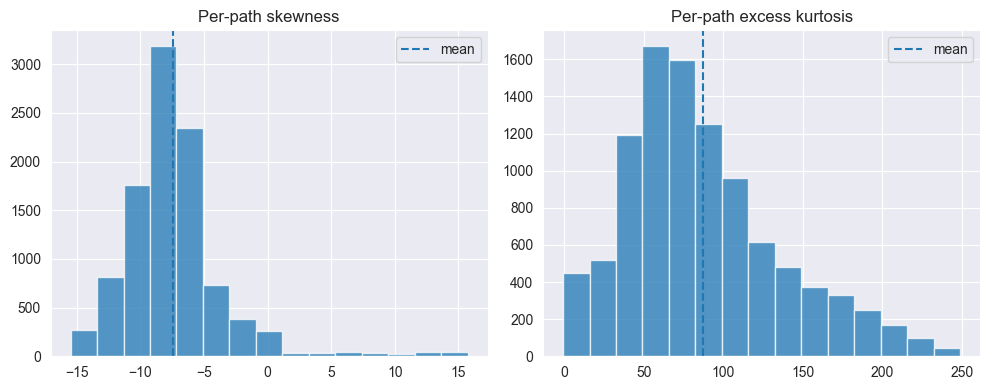

In [565]:
#Monte Carlo test for simulated Kou's log returns using above calibrated parameters

S0 =  296 #initial price of ticker on 2024-11-07
steps = 252 
paths = 10000
seed  = None  # set to None for non-reproducible randomness

# 1) Simulate
t, S_kou = kou_paths(S0, T, steps, paths, sigma, lam, p, eta1, eta2, r=r, seed=seed)  # (steps+1, paths)

# 2) Log-returns for each path (time along axis 0, paths along axis 1)
logR = np.diff(np.log(S_kou), axis=0)  # shape = (steps, paths)

# 3) Per-path skewness & (excess) kurtosis
skews   = stats.skew(logR, axis=0, bias=False)
ex_kurt = stats.kurtosis(logR, axis=0, fisher=True, bias=False)  # fisher=True -> excess kurtosis

# 4) Averages across paths (+ standard errors)
avg_skew      = np.mean(skews)
avg_ex_kurt   = np.mean(ex_kurt)
se_skew       = np.std(skews, ddof=1) / np.sqrt(paths)
se_ex_kurt    = np.std(ex_kurt, ddof=1) / np.sqrt(paths)

print(f"Paths: {paths}, Steps per path: {steps}")
print(f"Average skewness across paths:        {avg_skew: .4f}  (SE {se_skew:.4f})")
print(f"Average excess kurtosis across paths: {avg_ex_kurt: .4f}  (SE {se_ex_kurt:.4f})")

# 5) Optional: show distribution across paths
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(skews, bins=15, alpha=0.75)
ax[0].axvline(avg_skew, linestyle='--', label='mean')
ax[0].set_title("Per-path skewness")
ax[0].legend()

ax[1].hist(ex_kurt, bins=15, alpha=0.75)
ax[1].axvline(avg_ex_kurt, linestyle='--', label='mean')
ax[1].set_title("Per-path excess kurtosis")
ax[1].legend()
plt.tight_layout()
plt.show()
